<a href="https://colab.research.google.com/github/ctotti/INPE_Disciplinas/blob/main/Masters_Thesis/AHP/Matriz_Comparacao_Pareada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from tqdm import tqdm
from openpyxl.styles import Font, PatternFill
from openpyxl.utils import get_column_letter

# 1. DEFINIÇÃO INICIAL E FUNÇÕES AUXILIARES -----------------------------------

# Ordem de importância desejada (do mais importante para o menos)
ordem_importancia = [
    "Uso e Cobertura da Terra",
    "Distância à Estradas",
    "Concentração de Estabelecimentos",
    "Textura do Solo",
    "Tamanho de Imóveis",
    "Declividade"
]

def construir_matriz(valores):
    """Constroi a matriz de comparação a partir dos valores superiores à diagonal"""
    # Índices triangulares superiores (sem a diagonal)
    triu_indices = [(0,1), (0,2), (0,3), (0,4), (0,5),
                   (1,2), (1,3), (1,4), (1,5),
                   (2,3), (2,4), (2,5),
                   (3,4), (3,5),
                   (4,5)]

    mat = np.identity(6)
    for (i,j), val in zip(triu_indices, valores):
        mat[i,j] = val
        mat[j,i] = 1/val
    return mat

def calcular_consistencia(matriz):
    """Calcula a razão de consistência de uma matriz"""
    n = matriz.shape[0]
    W = matriz.sum(axis=1) / matriz.sum()
    lambda_max = (matriz.dot(W) / W).mean()
    IC = (lambda_max - n) / (n - 1)
    IR = 1.25  # Para n=6
    RC = IC / IR
    return RC, W, lambda_max, IC

def verificar_ordem(W, fatores, ordem_desejada):
    """Verifica se os pesos mantém a ordem desejada"""
    pesos = {f: w for f, w in zip(fatores, W)}
    for i in range(len(ordem_desejada)-1):
        if pesos[ordem_desejada[i]] < pesos[ordem_desejada[i+1]]:
            return False
    return True

# 2. OTIMIZAÇÃO DA MATRIZ ----------------------------------------------------

print("Iniciando otimização da matriz...")

# Fatores na ordem da matriz
fatores = ordem_importancia.copy()

# Valores fixos que mantêm a hierarquia básica
valores_fixos = {
    (0,1): 2,    # LULC > DistEstradas
    (0,2): 3,    # LULC > Concentração
    (1,2): 3,    # DistEstradas > Concentração
    (2,3): 2,    # Concentração > Textura
    (3,4): 3,    # Textura > Tamanho
    (4,5): 2     # Tamanho > Declividade
}

# Elementos que serão otimizados
elementos_variaveis = {
    (0,3): 5,    # LULC vs Textura
    (0,4): 6,    # LULC vs Tamanho
    (0,5): 7,    # LULC vs Declividade
    (1,3): 4,    # DistEstradas vs Textura
    (1,4): 6,    # DistEstradas vs Tamanho
    (1,5): 6,    # DistEstradas vs Declividade
    (2,4): 5,    # Concentração vs Tamanho
    (2,5): 6,    # Concentração vs Declividade
    (3,5): 4     # Textura vs Declividade
}

# Otimização
melhor_RC = float('inf')
melhor_matriz = None
melhor_W = None
melhor_lambda_max = None
melhor_IC = None

# Armazenar valores de RC das matrizes
RC_list = []

# Criar lista de elementos para variar
chaves = list(elementos_variaveis.keys())
valores_iniciais = [elementos_variaveis[k] for k in chaves]

# Testar combinações (limitando a variações de -1, 0, +1 para eficiência)
for variacoes in tqdm(product([-1, 0, 1], repeat=len(chaves)), desc="Otimizando"):
    # Aplicar variações
    novos_valores = []
    for i, k in enumerate(chaves):
        novo_val = valores_iniciais[i] + variacoes[i]
        novo_val = max(1, min(9, novo_val))  # Manter na escala Saaty
        novos_valores.append(novo_val)

    # Construir matriz completa
    valores_completos = valores_fixos.copy()
    for i, k in enumerate(chaves):
        valores_completos[k] = novos_valores[i]

    # Construir a matriz
    mat = construir_matriz([valores_completos[(i,j)] for (i,j) in sorted(valores_completos.keys())])

    # Calcular consistência
    RC, W, lambda_max, IC = calcular_consistencia(mat)

    # Armazena valores de RC e todos os pares variáveis
    rc_entry = {"RC": RC}
    for (i, j), val in zip(chaves, novos_valores):
      rc_entry[str((i, j))] = val  # salva como string para ser coluna
    RC_list.append(rc_entry)

    # Verificar ordem e consistência
    if verificar_ordem(W, fatores, ordem_importancia) and RC < melhor_RC:
        melhor_RC = RC
        melhor_matriz = mat.copy()
        melhor_W = W.copy()
        melhor_lambda_max = lambda_max
        melhor_IC = IC
        melhor_valores = valores_completos.copy()

# 3. EXPORTAÇÃO PARA EXCEL ---------------------------------------------------

print("\nPreparando arquivo Excel...")

# Criar DataFrames para exportação
df_matriz = pd.DataFrame(melhor_matriz, columns=fatores, index=fatores)
df_resultados = pd.DataFrame({
    'Fator': fatores,
    'Peso (W)': melhor_W,
    'Soma Linhas': melhor_matriz.sum(axis=1),
    'Produto Vetorial (D*W)': melhor_matriz.dot(melhor_W),
    'Lambda': melhor_matriz.dot(melhor_W) / melhor_W
})

# # Criar arquivo Excel
# with pd.ExcelWriter('matriz_comparacao_otimizada.xlsx', engine='openpyxl') as writer:
#     # Salvar matriz principal
#     df_matriz.to_excel(writer, sheet_name='Matriz Comparação', float_format="%.2f")

#     # Salvar resultados
#     df_resultados.to_excel(writer, sheet_name='Cálculos', index=False, float_format="%.4f")

#     # Acessar as planilhas para formatação
#     workbook = writer.book
#     ws_matriz = writer.sheets['Matriz Comparação']
#     ws_calc = writer.sheets['Cálculos']

#     # Formatar a planilha da matriz
#     header_fill = PatternFill(start_color='4472C4', end_color='4472C4', fill_type='solid')
#     header_font = Font(color='FFFFFF', bold=True)

#     for col in range(1, len(fatores)+2):
#         ws_matriz.cell(row=1, column=col).fill = header_fill
#         ws_matriz.cell(row=1, column=col).font = header_font
#         ws_matriz.cell(row=col, column=1).fill = header_fill
#         ws_matriz.cell(row=col, column=1).font = header_font

#     # Formatar a planilha de cálculos
#     for col in range(1, len(df_resultados.columns)+1):
#         ws_calc.cell(row=1, column=col).fill = header_fill
#         ws_calc.cell(row=1, column=col).font = header_font

#     # Adicionar métricas de consistência
#     ws_calc['G1'] = 'Métricas de Consistência'
#     ws_calc['G2'] = f'λmax = {melhor_lambda_max:.3f}'
#     ws_calc['G3'] = f'IC = {melhor_IC:.3f}'
#     ws_calc['G4'] = f'IR = 1.25'
#     ws_calc['G5'] = f'RC = {melhor_RC:.3f}'
#     ws_calc['G6'] = 'Consistente' if melhor_RC < 0.1 else 'Inconsistente'

#     # Formatar células de métricas
#     for row in range(1, 7):
#         ws_calc.cell(row=row, column=7).font = Font(bold=True)

#     # Ajustar largura das colunas
#     for sheet in [ws_matriz, ws_calc]:
#         for column in sheet.columns:
#             max_length = 0
#             column_letter = get_column_letter(column[0].column)

#             for cell in column:
#                 try:
#                     if len(str(cell.value)) > max_length:
#                         max_length = len(str(cell.value))
#                 except:
#                     pass

#             adjusted_width = (max_length + 2) * 1.2
#             sheet.column_dimensions[column_letter].width = adjusted_width

# 4. RELATÓRIO FINAL ---------------------------------------------------------

print("\nRESULTADOS DA OTIMIZAÇÃO:")
print(f"\nMelhor Razão de Consistência encontrada: {melhor_RC:.3f}")
print("A matriz é consistente?" + (" ✅ Sim (RC < 0.1)" if melhor_RC < 0.1 else " ❌ Não (RC ≥ 0.1)"))

print("\nValores otimizados da matriz:")
for (i,j), val in sorted(melhor_valores.items()):
    original = elementos_variaveis.get((i,j), valores_fixos.get((i,j), 1))
    print(f"{fatores[i]} vs {fatores[j]}: {val} (original: {original})")

print("\nDistribuição final dos pesos:")
for f, w in zip(fatores, melhor_W):
    print(f"{f.ljust(30)}: {w:.4f}")

print("\nVerificação da ordem de importância:")
ordem_correta = True
for i in range(len(fatores)-1):
    if melhor_W[i] < melhor_W[i+1]:
        ordem_correta = False
    print(f"{fatores[i]} ({melhor_W[i]:.4f}) {'>' if melhor_W[i] >= melhor_W[i+1] else '<'} {fatores[i+1]} ({melhor_W[i+1]:.4f})")

print("\nArquivo 'matriz_comparacao_otimizada.xlsx' gerado com sucesso!")

Iniciando otimização da matriz...


Otimizando: 19683it [00:01, 11006.56it/s]


Preparando arquivo Excel...

RESULTADOS DA OTIMIZAÇÃO:

Melhor Razão de Consistência encontrada: 0.037
A matriz é consistente? ✅ Sim (RC < 0.1)

Valores otimizados da matriz:
Uso e Cobertura da Terra vs Distância à Estradas: 2 (original: 2)
Uso e Cobertura da Terra vs Concentração de Estabelecimentos: 3 (original: 3)
Uso e Cobertura da Terra vs Textura do Solo: 4 (original: 5)
Uso e Cobertura da Terra vs Tamanho de Imóveis: 7 (original: 6)
Uso e Cobertura da Terra vs Declividade: 8 (original: 7)
Distância à Estradas vs Concentração de Estabelecimentos: 3 (original: 3)
Distância à Estradas vs Textura do Solo: 3 (original: 4)
Distância à Estradas vs Tamanho de Imóveis: 6 (original: 6)
Distância à Estradas vs Declividade: 7 (original: 6)
Concentração de Estabelecimentos vs Textura do Solo: 2 (original: 2)
Concentração de Estabelecimentos vs Tamanho de Imóveis: 4 (original: 5)
Concentração de Estabelecimentos vs Declividade: 5 (original: 6)
Textura do Solo vs Tamanho de Imóveis: 3 (origin

In [14]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Converter em DataFrame
# df_rc = pd.DataFrame(RC_list)

# # Plotar as 100 primeiras
# plt.figure(figsize=(14, 6))
# sns.barplot(x=df_rc.index[:56], y=df_rc.RC[:56], palette="Blues_r")
# plt.axhline(0.1, color='red', linestyle='--', label='Limite de consistência (0.1)')
# plt.xlabel("Matriz testada (primeiras 100)")
# plt.ylabel("Razão de Consistência (RC)")
# plt.title("RC das 100 primeiras matrizes de comparação pareada testadas")
# plt.legend()
# plt.tight_layout()
# plt.show()


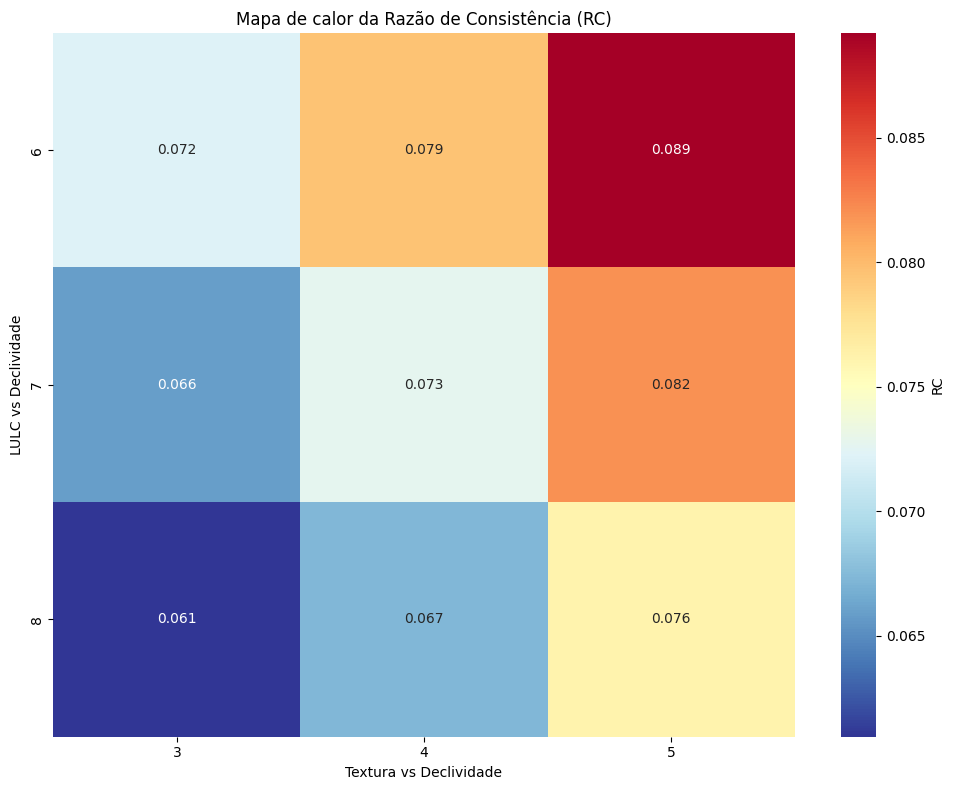

In [13]:
df_heatmap = pd.DataFrame(RC_list)
heatmap_data = df_heatmap.pivot_table(index="(0,5)", columns="(3,5)", values="RC")

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="RdYlBu_r", cbar_kws={'label': 'RC'})
plt.title("Mapa de calor da Razão de Consistência (RC)")
plt.xlabel("Textura vs Declividade")
plt.ylabel("LULC vs Declividade")
plt.tight_layout()
plt.show()


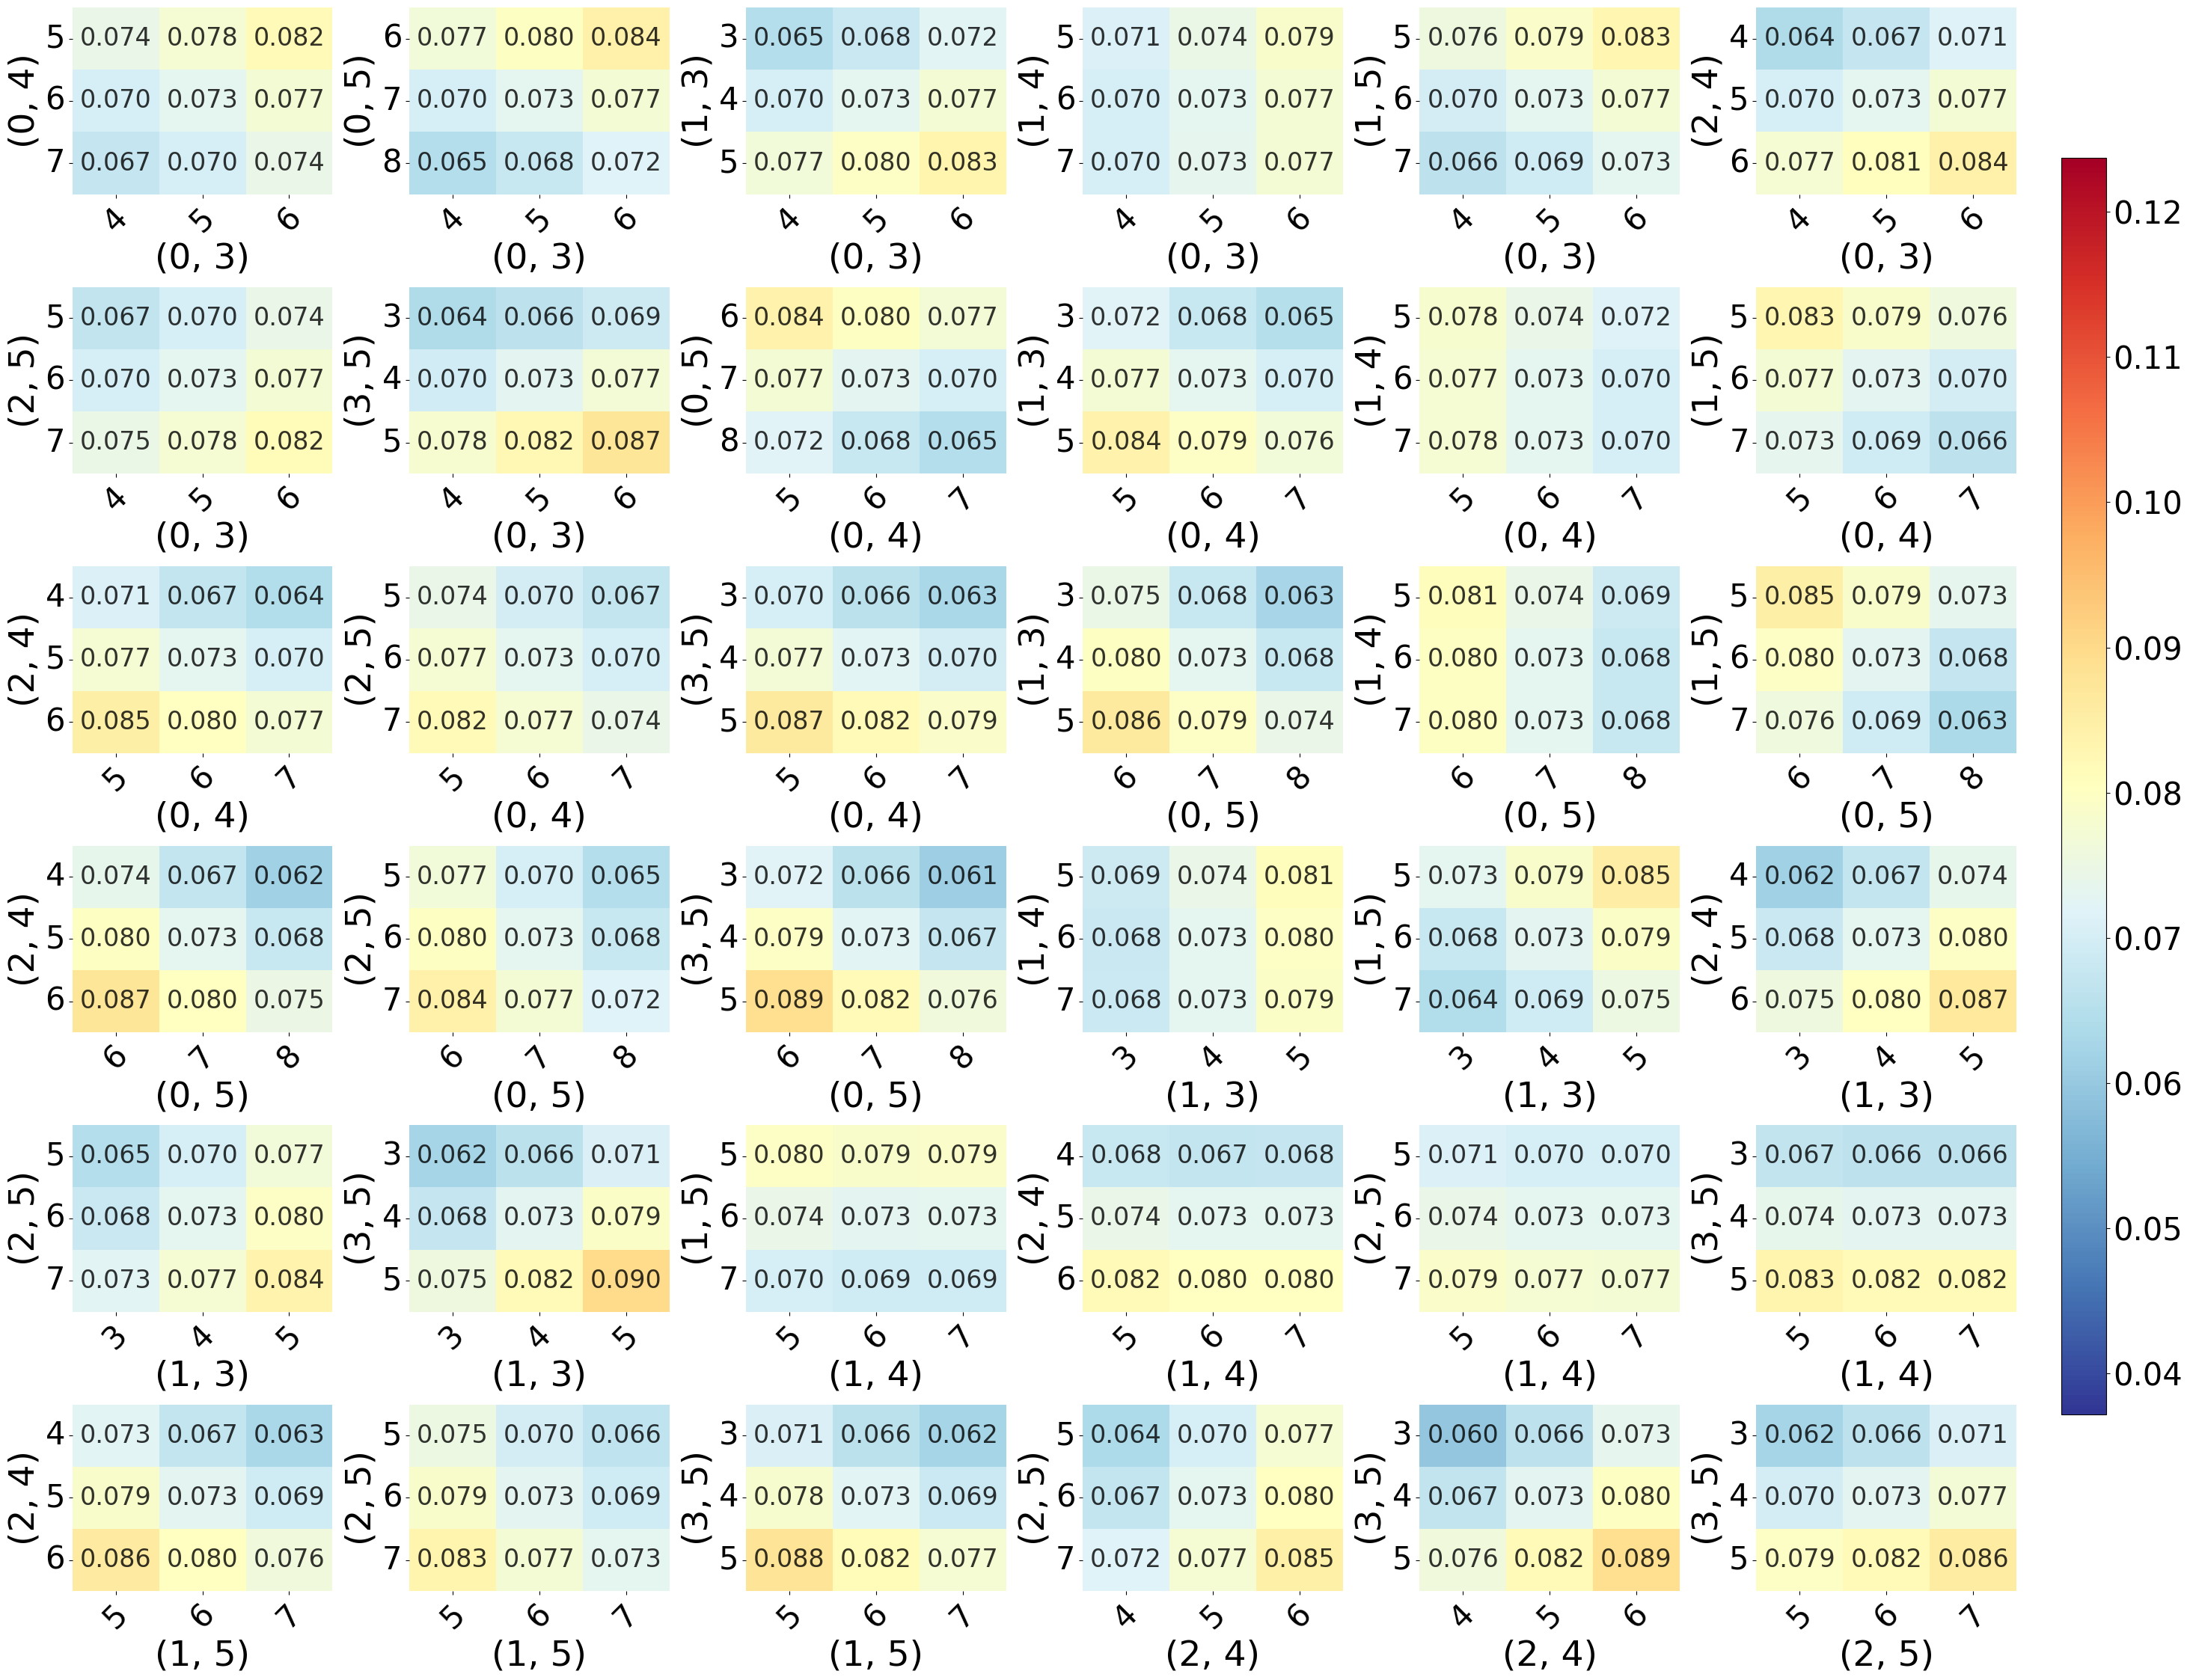

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import pandas as pd
import numpy as np

# Supõe que RC_list já está definido
df_heatmap = pd.DataFrame(RC_list)

pares_nomes = {
    "(0,3)": "LULC vs Textura",
    "(0,4)": "LULC vs Tamanho",
    "(0,5)": "LULC vs Declividade",
    "(1,3)": "Dist. Estradas vs Textura",
    "(1,4)": "Dist. Estradas vs Tamanho",
    "(1,5)": "Dist. Estradas vs Declividade",
    "(2,4)": "Concentração vs Tamanho",
    "(2,5)": "Concentração vs Declividade",
    "(3,5)": "Textura vs Declividade"
}

comparisons = [col for col in df_heatmap.columns if col != "RC"]

# Geração dos heatmaps
heatmaps = []
for i in range(len(comparisons)):
    for j in range(i + 1, len(comparisons)):
        x, y = comparisons[i], comparisons[j]
        pivot = df_heatmap.pivot_table(index=y, columns=x, values="RC")
        nome_x = pares_nomes.get(x, x)
        nome_y = pares_nomes.get(y, y)
        heatmaps.append((nome_x, nome_y, pivot))

# Valores globais
vmin = df_heatmap["RC"].min()
vmax = df_heatmap["RC"].max()

# Layout
n = len(heatmaps)
cols = 6
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for ax, (nome_x, nome_y, pivot) in zip(axes, heatmaps):
    sns.heatmap(
        pivot,
        ax=ax,
        cmap="RdYlBu_r",
        vmin=vmin,
        vmax=vmax,
        annot=True,                                        # ✅ Ativa os valores nas células
        fmt=".3f",                                         # ✅ Três casas decimais
        annot_kws={"size": 24, "color": (0, 0, 0, 0.8)},   # ✅ Tamanho da fonte nos valores
        cbar=False                                          # ✅ Desativa a barra de cor
)


    ax.set_xticklabels([str(label) for label in pivot.columns], rotation=45)
    ax.set_yticklabels([str(label) for label in pivot.index], rotation=0)
    ax.set_xlabel(nome_x, fontsize=34)
    ax.set_ylabel(nome_y, fontsize=34)
    ax.tick_params(axis='both', labelsize=30)

for ax in axes[n:]:
    ax.axis('off')

# Ajustes de layout e colorbar global
plt.tight_layout(rect=[0, 0, 0.9, 0.94])
plt.subplots_adjust(right=0.9)

# Adiciona colorbar unificada
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="RdYlBu_r", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=30)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# cbar.set_label("Consistency Ratio (RC)", fontsize=18)

# # Adiciona legenda explicativa das variáveis
# legenda_texto = "0 - LULC classes; 1 - Distance to roads; 2 - Establishment density; 3 - Soil texture; 4 - Property size; 5 - Slope"
# fig.text(0.5, -0.04, legenda_texto, ha='center', va='top', fontsize=34, family='monospace')
# # fig.text(0.5, -0.04, legenda_texto, ha='left', va='center', rotation=90, fontsize=34, family='monospace')

# Título geral
# plt.suptitle("Heatmaps of RC by Pairwise Factor Combinations", fontsize=18)

# Salvar imagem no drive
plt.savefig("ConsistencyRatio_CR_SensibilityAnalysis_6col.png", dpi=300, bbox_inches='tight')

plt.show()


## Testes com
- Distancia a estradas > LULC
- LULC > Densidade de estabelecimentos > Distancia a estradas

In [79]:
# Comparação de três cenários para matriz AHP

import numpy as np
import pandas as pd
from itertools import product
from tqdm import tqdm

# -------------------- Funções auxiliares --------------------
def construir_matriz(valores):
    triu_indices = [(0,1), (0,2), (0,3), (0,4), (0,5),
                    (1,2), (1,3), (1,4), (1,5),
                    (2,3), (2,4), (2,5),
                    (3,4), (3,5),
                    (4,5)]
    mat = np.identity(6)
    for (i,j), val in zip(triu_indices, valores):
        mat[i,j] = val
        mat[j,i] = 1/val
    return mat

def calcular_RC(matriz):
    n = matriz.shape[0]
    W = matriz.sum(axis=1) / matriz.sum()
    lambda_max = (matriz.dot(W) / W).mean()
    IC = (lambda_max - n) / (n - 1)
    IR = 1.25
    RC = IC / IR
    return RC, W

def otimizar(valores_fixos, variaveis, ordem_desejada):
    melhor_RC = float('inf')
    melhor_W = None
    melhor_matriz = None
    chaves = list(variaveis.keys())
    base_vals = [variaveis[k] for k in chaves]

    for variacoes in product([-1, 0, 1], repeat=len(chaves)):
        novos_vals = [max(1, min(9, base_vals[i] + variacoes[i])) for i in range(len(chaves))]
        todos_vals = valores_fixos.copy()
        for i, k in enumerate(chaves):
            todos_vals[k] = novos_vals[i]

        mat = construir_matriz([todos_vals[k] for k in sorted(todos_vals)])
        RC, W = calcular_RC(mat)

        pesos = {f: w for f, w in zip(ordem_desejada, W)}
        ordem_ok = all(pesos[ordem_desejada[i]] >= pesos[ordem_desejada[i+1]] for i in range(len(ordem_desejada)-1))

        if ordem_ok and RC < melhor_RC:
            melhor_RC = RC
            melhor_W = W.copy()
            melhor_matriz = mat.copy()

    return melhor_RC, melhor_W

# -------------------- Configurações iniciais --------------------
fatores = [
    "LULC classes",
    "Distance to roads",
    "Establishment density",
    "Soil texture",
    "Property size",
    "Slope"
]

valores_fixos = {
    (2,3): 2,   # Concentração > Textura
    (3,4): 3,   # Textura > Tamanho
    (4,5): 2    # Tamanho > Declividade
}

variaveis_comuns = {
    (0,3): 5,
    (0,4): 6,
    (0,5): 7,
    (1,3): 4,
    (1,4): 6,
    (1,5): 6,
    (2,4): 5,
    (2,5): 6,
    (3,5): 4
}

cases = {
    "Case 1 - LULC > Distance to roads": {(0,1): 2, (0,2): 3, (1,2): 3},
    "Case 2 - Distance to roads > LULC": {(1,0): 2, (1,2): 3, (0,2): 2},
    "Case 3 - LULC > Establishment density > Distance to roads": {(0,2): 3, (2,1): 2, (0,1): 4}
}

# -------------------- Execução dos três cenários --------------------
for nome, pares in cases.items():
    print(f"\n{nome}")
    fixos = valores_fixos.copy()
    for (i,j), val in pares.items():
        fixos[(min(i,j), max(i,j))] = val if i < j else 1/val

    RC, W = otimizar(fixos, variaveis_comuns, fatores)
    print(f"RC = {RC:.4f}")
    for f, w in zip(fatores, W):
        print(f"{f.ljust(35)}: {w:.4f}")



Case 1 - LULC > Distance to roads
RC = 0.0372
LULC classes                       : 0.3451
Distance to roads                  : 0.2830
Establishment density              : 0.1748
Soil texture                       : 0.1116
Property size                      : 0.0537
Slope                              : 0.0318

Case 2 - Distance to roads > LULC
RC = 0.0397
LULC classes                       : 0.3142
Distance to roads                  : 0.3072
Establishment density              : 0.1792
Soil texture                       : 0.1129
Property size                      : 0.0544
Slope                              : 0.0321

Case 3 - LULC > Establishment density > Distance to roads
RC = 0.0590
LULC classes                       : 0.3832
Distance to roads                  : 0.2094
Establishment density              : 0.2035
Soil texture                       : 0.1147
Property size                      : 0.0557
Slope                              : 0.0335


Gerando RCs para: Case 1
Gerando RCs para: Case 2
Gerando RCs para: Case 3


/tmp/ipython-input-84-504001511.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x="Case", y="CR", palette=custom_palette)


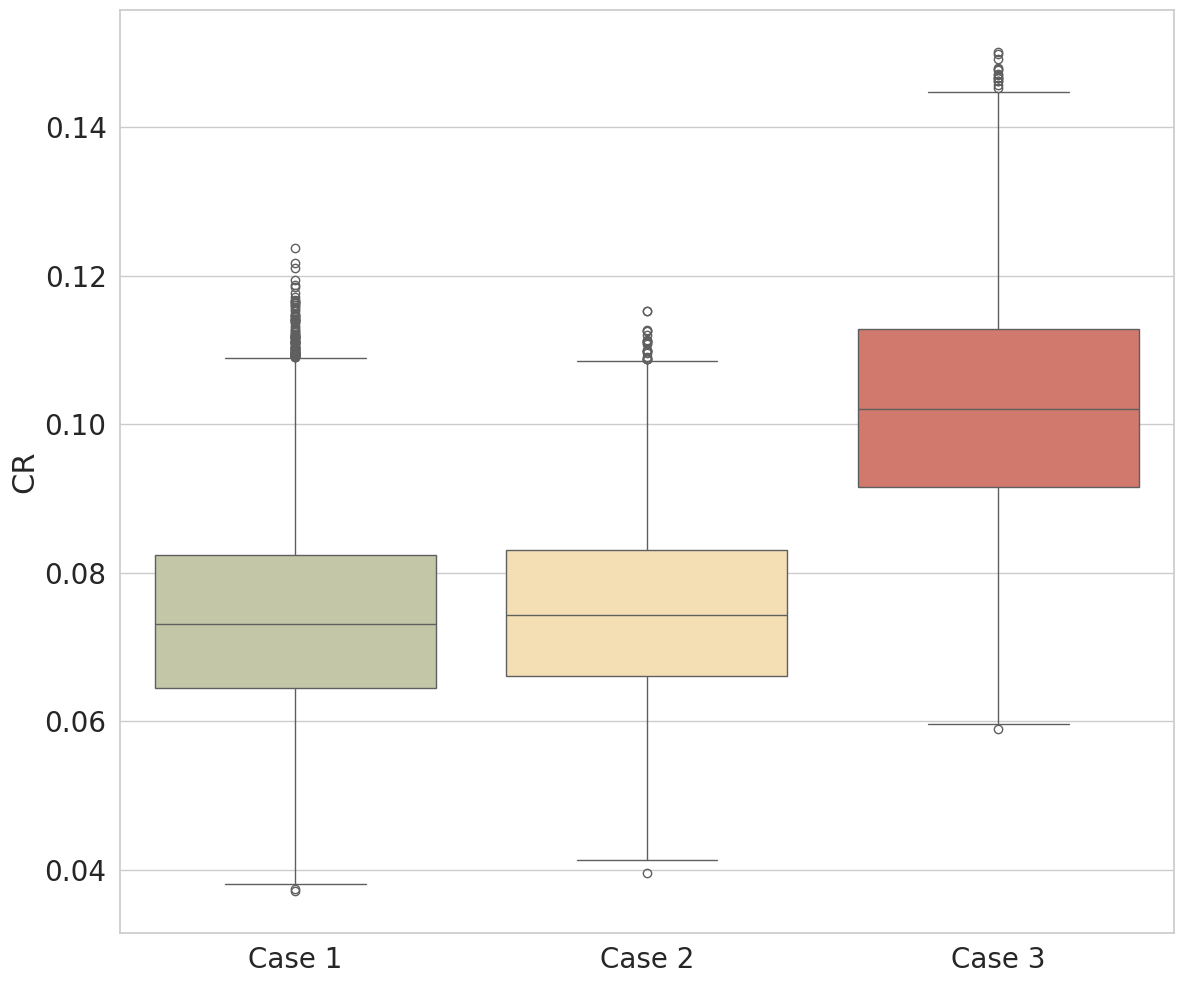

In [84]:
import numpy as np
import pandas as pd
from itertools import product
from tqdm import tqdm

# -------------------- Funções auxiliares --------------------
def construir_matriz(valores):
    triu_indices = [(0,1), (0,2), (0,3), (0,4), (0,5),
                    (1,2), (1,3), (1,4), (1,5),
                    (2,3), (2,4), (2,5),
                    (3,4), (3,5),
                    (4,5)]
    mat = np.identity(6)
    for (i,j), val in zip(triu_indices, valores):
        mat[i,j] = val
        mat[j,i] = 1/val
    return mat

def calcular_RC(matriz):
    n = matriz.shape[0]
    W = matriz.sum(axis=1) / matriz.sum()
    lambda_max = (matriz.dot(W) / W).mean()
    IC = (lambda_max - n) / (n - 1)
    IR = 1.25
    RC = IC / IR
    return RC, W

def gerar_variacoes_RC(valores_fixos, variaveis, ordem_desejada, n_amostras=1000):
    resultados = []
    chaves = list(variaveis.keys())
    base_vals = [variaveis[k] for k in chaves]

    for variacoes in product([-1, 0, 1], repeat=len(chaves)):
        novos_vals = [max(1, min(9, base_vals[i] + variacoes[i])) for i in range(len(chaves))]
        todos_vals = valores_fixos.copy()
        for i, k in enumerate(chaves):
            todos_vals[k] = novos_vals[i]

        try:
            mat = construir_matriz([todos_vals[k] for k in sorted(todos_vals)])
            RC, W = calcular_RC(mat)

            pesos = {f: w for f, w in zip(ordem_desejada, W)}
            ordem_ok = all(pesos[ordem_desejada[i]] >= pesos[ordem_desejada[i+1]] for i in range(len(ordem_desejada)-1))

            if ordem_ok:
                resultados.append(RC)
        except:
            continue

    return resultados

# -------------------- Configurações --------------------
fatores = [
    "Uso e Cobertura da Terra",
    "Distância à Estradas",
    "Concentração de Estabelecimentos",
    "Textura do Solo",
    "Tamanho de Imóveis",
    "Declividade"
]

valores_fixos = {
    (2,3): 2,
    (3,4): 3,
    (4,5): 2
}

variaveis_comuns = {
    (0,3): 5,
    (0,4): 6,
    (0,5): 7,
    (1,3): 4,
    (1,4): 6,
    (1,5): 6,
    (2,4): 5,
    (2,5): 6,
    (3,5): 4
}

cases = {
    "Case 1": {(0,1): 2, (0,2): 3, (1,2): 3},                                                             # LULC > Distance to roads
    "Case 2": {(1,0): 2, (1,2): 3, (0,2): 2},                                                             # Distance to roads > LULC
    "Case 3": {(0,2): 3, (2,1): 2, (0,1): 4}                                                              # LULC > Establishment density > Distance to roads
}

# -------------------- Execução --------------------
dados_boxplot = []

for nome, pares in cases.items():
    print(f"Gerando RCs para: {nome}")
    fixos = valores_fixos.copy()
    for (i,j), val in pares.items():
        fixos[(min(i,j), max(i,j))] = val if i < j else 1/val

    RCs = gerar_variacoes_RC(fixos, variaveis_comuns, fatores)

    for rc in RCs:
        dados_boxplot.append({"Case": nome, "CR": rc})

# -------------------- DataFrame para plot --------------------
df_box = pd.DataFrame(dados_boxplot)

# -------------------- Plot (opcional) --------------------
import seaborn as sns
import matplotlib.pyplot as plt

custom_palette = ["#c9cba3", "#ffe1a8", "#e26d5c"]

plt.figure(figsize=(12, 10))
sns.boxplot(data=df_box, x="Case", y="CR", palette=custom_palette)

# Tamanhos das fontes
plt.xticks(fontsize=20)  # Tamanho dos rótulos no eixo X (categorias)
plt.yticks(fontsize=20)  # Tamanho dos valores no eixo Y
plt.ylabel("CR", fontsize=22)  # Título do eixo Y
plt.xlabel("")  # Remove o label do eixo X
# plt.title("Variação de CR por Cenário", fontsize=18)  # Título do gráfico

plt.tight_layout()

# Salvar imagem com alta resolução e sem cortes
plt.savefig("Cases_BoxPlot_SensibilityAnalisys.png", dpi=300, bbox_inches='tight')

plt.show()